# Step 1: Import Libraries for this Project

In [1]:
### Only Numpy Library is necessary for this project and all the layers are compiled with Numpy.
import numpy as np 
import pickle 
import sys
import time
import warnings
warnings.filterwarnings('ignore')
import pdb          ### library for debugging
import matplotlib.pyplot as plt
np.random.seed(1000)

# Step 2: Convolutional Layer Definition 

In [2]:
class Convolution2D:
    # Initialization of convolutional layer
    def __init__(self, inputs_channel, num_filters, kernel_size, padding, stride, learning_rate, name):
        # weight size: (F, C, K, K)
        # bias size: (F) 
        self.F = num_filters
        self.K = kernel_size
        self.C = inputs_channel

        self.weights = np.zeros((self.F, self.C, self.K, self.K))
        self.bias = np.zeros((self.F, 1))
        for i in range(0,self.F):
            self.weights[i,:,:,:] = np.random.normal(loc=0, scale=np.sqrt(1./(self.C*self.K*self.K)), size=(self.C, self.K, self.K))

        self.p = padding
        self.s = stride
        self.lr = learning_rate
        self.name = name
    
    # Padding Layer 
    def zero_padding(self, inputs, size):
        w, h = inputs.shape[0], inputs.shape[1]
        new_w = 2 * size + w
        new_h = 2 * size + h
        out = np.zeros((new_w, new_h))
        out[size:w+size, size:h+size] = inputs
        return out
    
    # Forward propagation
    def forward(self, inputs):
        # input size: (C, W, H)
        # output size: (N, F ,WW, HH)
        C = inputs.shape[0]
        W = inputs.shape[1]+2*self.p
        H = inputs.shape[2]+2*self.p
        self.inputs = np.zeros((C, W, H))
        for c in range(inputs.shape[0]):
            self.inputs[c,:,:] = self.zero_padding(inputs[c,:,:], self.p)
        WW = (W - self.K)//self.s + 1
        HH = (H - self.K)//self.s + 1
        feature_maps = np.zeros((self.F, WW, HH))
        for f in range(self.F):
            for w in range(WW):
                for h in range(HH):
                    feature_maps[f,w,h]=np.sum(self.inputs[:,w:w+self.K,h:h+self.K]*self.weights[f,:,:,:])+self.bias[f]

        return feature_maps
    
    # Backward Propagation
    def backward(self, dy):

        C, W, H = self.inputs.shape
        dx = np.zeros(self.inputs.shape)
        dw = np.zeros(self.weights.shape)
        db = np.zeros(self.bias.shape)

        F, W, H = dy.shape
        for f in range(F):
            for w in range(W):
                for h in range(H):
                    dw[f,:,:,:]+=dy[f,w,h]*self.inputs[:,w:w+self.K,h:h+self.K]
                    dx[:,w:w+self.K,h:h+self.K]+=dy[f,w,h]*self.weights[f,:,:,:]

        for f in range(F):
            db[f] = np.sum(dy[f, :, :])

        self.weights -= self.lr * dw
        self.bias -= self.lr * db
        return dx
    
    # Function for extract the weights and bias for storage
    def extract(self):
        return {self.name+'.weights':self.weights, self.name+'.bias':self.bias}
    
    # Feed the pretrained weights and bias for models 
    def feed(self, weights, bias):
        self.weights = weights
        self.bias = bias

# Step 3: MaxPooling Layer Definition

In [3]:
class Maxpooling2D:
    # Initialization of MaxPooling layer
    def __init__(self, pool_size, stride, name):
        self.pool = pool_size
        self.s = stride
        self.name = name
    
    # Forward propagation
    def forward(self, inputs):
        self.inputs = inputs
        C, W, H = inputs.shape
        new_width = (W - self.pool)//self.s + 1
        new_height = (H - self.pool)//self.s + 1
        out = np.zeros((C, new_width, new_height))
        for c in range(C):
            for w in range(W//self.s):
                for h in range(H//self.s):
                    out[c, w, h] = np.max(self.inputs[c, w*self.s:w*self.s+self.pool, h*self.s:h*self.s+self.pool])
        return out
    
    # Backward propagation
    def backward(self, dy):
        C, W, H = self.inputs.shape
        dx = np.zeros(self.inputs.shape)
        
        for c in range(C):
            for w in range(0, W, self.pool):
                for h in range(0, H, self.pool):
                    st = np.argmax(self.inputs[c,w:w+self.pool,h:h+self.pool])
                    (idx, idy) = np.unravel_index(st, (self.pool, self.pool))
                    dx[c, w+idx, h+idy] = dy[c, w//self.pool, h//self.pool]
        return dx
    
    # No weights and bias for pooling layer to store
    def extract(self):
        return 

# Step 4: Fully-Connected Layer Definition

In [4]:
class FullyConnected:
    # Initialization of Fully-Connected Layer
    def __init__(self, num_inputs, num_outputs, learning_rate, name):
        self.weights = 0.01*np.random.rand(num_inputs, num_outputs)
        self.bias = np.zeros((num_outputs, 1))
        self.lr = learning_rate
        self.name = name
    
    # Forward Propagation
    def forward(self, inputs):
        self.inputs = inputs
        return np.dot(self.inputs, self.weights) + self.bias.T
    
    # Backward Propagation
    def backward(self, dy):

        if dy.shape[0] == self.inputs.shape[0]:
            dy = dy.T
        dw = dy.dot(self.inputs)
        db = np.sum(dy, axis=1, keepdims=True)
        dx = np.dot(dy.T, self.weights.T)

        self.weights -= self.lr * dw.T
        self.bias -= self.lr * db

        return dx
    
    # Extract weights and bias for storage
    def extract(self):
        return {self.name+'.weights':self.weights, self.name+'.bias':self.bias}
    
    # Feed the pretrained weights and bias for models 
    def feed(self, weights, bias):
        self.weights = weights
        self.bias = bias

### Flatten function to convert 4D feature maps into 3D feature vectors
class Flatten:
    def __init__(self):
        pass
    def forward(self, inputs):
        self.C, self.W, self.H = inputs.shape
        return inputs.reshape(1, self.C*self.W*self.H)
    def backward(self, dy):
        return dy.reshape(self.C, self.W, self.H)
    def extract(self):
        return

# Step 5: Activation Function Definition

In [5]:
### ReLU activation function
class ReLu:
    def __init__(self):
        pass
    def forward(self, inputs):
        self.inputs = inputs
        ret = inputs.copy()
        ret[ret < 0] = 0
        return ret
    def backward(self, dy):
        dx = dy.copy()
        dx[self.inputs < 0] = 0
        return dx
    def extract(self):
        return

### Softmax activation function
class Softmax:
    def __init__(self):
        pass
    def forward(self, inputs):
        exp = np.exp(inputs, dtype=float)
        self.out = exp/np.sum(exp)
        return self.out
    def backward(self, dy):
        return self.out.T - dy.reshape(dy.shape[0],1)
    def extract(self):
        return

# Step 6: Loss Function Definition

In [6]:
### Cross-Entropy Loss function
def cross_entropy(inputs, labels):
    out_num = labels.shape[0]
    p = np.sum(labels.reshape(1,out_num)*inputs)
    loss = -np.log(p)
    return loss

# Step 7: Neural Network Definition

In [7]:
"""
This step shows how to define a simple CNN with all kind of layers which we introduced above.
"""
class Net:
    def __init__(self):
        # input: 28x28
        # output: 1x4 (only a subset, containing 4 classes, of the MNIST will be used)
        # conv1:  {(28-5+0x0)/2+1} -> (12x12x6) (output size of convolutional layer)
        # maxpool2: {(12-2)/2+1} -> (6x6)x6 (output size of pooling layer)
        # fc3: 216 -> 32
        # fc4: 32 -> 4
        # softmax: 4 -> 4
        lr = 0.001
        self.layers = []
        self.layers.append(Convolution2D(inputs_channel=1, num_filters=6, kernel_size=5, padding=0, stride=2, learning_rate=lr, name='conv1'))
        self.layers.append(ReLu())
        self.layers.append(Maxpooling2D(pool_size=2, stride=2, name='maxpool2'))
        self.layers.append(Flatten())
        self.layers.append(FullyConnected(num_inputs=6*6*6, num_outputs=32, learning_rate=lr, name='fc3'))
        self.layers.append(ReLu())
        self.layers.append(FullyConnected(num_inputs=32, num_outputs=4, learning_rate=lr, name='fc4'))
        self.layers.append(Softmax())
        self.lay_num = len(self.layers)
    
    ### Function for train the network
    def train(self, data, label):
        batch_size = data.shape[0]
        loss = 0
        acc = 0
        for b in range(batch_size):
            x = data[b]
            y = label[b]
            # forward pass
            for l in range(self.lay_num):
                output = self.layers[l].forward(x)
                x = output
            loss += cross_entropy(output, y)
            if np.argmax(output) == np.argmax(y):
                acc += 1
            # backward pass
            dy = y
            for l in range(self.lay_num-1, -1, -1):
                dout = self.layers[l].backward(dy)
                dy = dout
        return loss, acc



# Step 8: Create your own subset samples of MNIST

In [8]:
from precode import *
"""
The subset of MNIST is created based on the last 4 digits of your ASUID. There are 4 categories and all returned 
samples are preprocessed and shuffled. 
"""
print('Loading data......')
sub_train_images, sub_train_labels, sub_test_images, sub_test_labels = init_subset('8129') # input your ASUID last 4 digits here to generate the subset samples of MNIST for training and testing

Loading data......
Preparing data......


# Step 9: Initial Network and do the Training and Testing process

In [9]:
net = Net()
epoch = 10            ### Default number of epochs
batch_size = 100      ### Default batch size
num_batch = sub_train_images.shape[0]/batch_size

test_size = sub_test_images.shape[0]      # Obtain the size of testing samples
train_size = sub_train_images.shape[0]    # Obtain the size of training samples

training_accuracy_values = []
testing_accuracy_values = []
training_loss_values = []
testing_loss_values = []

### ---------- ###
"""
Please compile your own evaluation code based on the training code 
to evaluate the trained network.
The function name and the inputs of the function have been predifined and please finish the remaining part.
"""
def evaluate(net, images, labels):
    acc = 0    
    loss = 0
    batch_size = 1

    #pass
    for batch_index in range(0, images.shape[0], batch_size):
        
        if batch_index + batch_size < images.shape[0]:
            data = images[batch_index:batch_index+batch_size]
            label = labels[batch_index:batch_index + batch_size]
        else:
            data = images[batch_index:images.shape[0]]
            label = labels[batch_index:labels.shape[0]]

        for b in range(len(data)):
            x = data[b]
            y = label[b]

            for l in range(net.lay_num):
                output = net.layers[l].forward(x)
                x = output

            loss += cross_entropy(output, y)
            if np.argmax(output) == np.argmax(y):
                acc += 1
                
    loss /= len(images)
    acc /= len(images)

    return acc, loss

### Start training process
for e in range(epoch):
    total_acc = 0    
    total_loss = 0
    print('Epoch %d' % e)
    for batch_index in range(0, sub_train_images.shape[0], batch_size):
        # batch input
        if batch_index + batch_size < sub_train_images.shape[0]:
            data = sub_train_images[batch_index:batch_index+batch_size]
            label = sub_train_labels[batch_index:batch_index + batch_size]
        else:
            data = sub_train_images[batch_index:sub_train_images.shape[0]]
            label = sub_train_labels[batch_index:sub_train_labels.shape[0]]
        # Compute the remaining time
        start_time = time.time()
        batch_loss,batch_acc = net.train(data, label)  # Train the network with samples in one batch 
        
        end_time = time.time()
        batch_time = end_time-start_time
        remain_time = (sub_train_images.shape[0]-batch_index)/batch_size*batch_time
        hrs = int(remain_time/3600)
        mins = int((remain_time/60-hrs*60))
        secs = int(remain_time-mins*60-hrs*3600)
        print('=== Iter:{0:d} === Remain: {1:d} Hrs {2:d} Mins {3:d} Secs ==='.format(int(batch_index+batch_size),int(hrs),int(mins),int(secs)))
    
    # Print out the Performance
    train_acc, train_loss = evaluate(net, sub_train_images, sub_train_labels)  # Use the evaluation code to obtain the training accuracy and loss
    test_acc, test_loss = evaluate(net, sub_test_images, sub_test_labels)      # Use the evaluation code to obtain the testing accuracy and loss
    print('=== Epoch:{0:d} Train Size:{1:d}, Train Acc:{2:.3f}, Train Loss:{3:.3f} ==='.format(e, train_size,train_acc,train_loss))

    print('=== Epoch:{0:d} Test Size:{1:d}, Test Acc:{2:.3f}, Test Loss:{3:.3f} ==='.format(e, test_size, test_acc,test_loss))

    training_accuracy_values.append(train_acc)
    training_loss_values.append(train_loss)
    testing_accuracy_values.append(test_acc)
    testing_loss_values.append(test_loss)


Epoch 0
=== Iter:100 === Remain: 0 Hrs 1 Mins 50 Secs ===
=== Iter:200 === Remain: 0 Hrs 1 Mins 40 Secs ===
=== Iter:300 === Remain: 0 Hrs 1 Mins 34 Secs ===
=== Iter:400 === Remain: 0 Hrs 1 Mins 28 Secs ===
=== Iter:500 === Remain: 0 Hrs 1 Mins 32 Secs ===
=== Iter:600 === Remain: 0 Hrs 1 Mins 28 Secs ===
=== Iter:700 === Remain: 0 Hrs 1 Mins 16 Secs ===
=== Iter:800 === Remain: 0 Hrs 1 Mins 6 Secs ===
=== Iter:900 === Remain: 0 Hrs 1 Mins 3 Secs ===
=== Iter:1000 === Remain: 0 Hrs 0 Mins 57 Secs ===
=== Iter:1100 === Remain: 0 Hrs 0 Mins 53 Secs ===
=== Iter:1200 === Remain: 0 Hrs 0 Mins 47 Secs ===
=== Iter:1300 === Remain: 0 Hrs 0 Mins 41 Secs ===
=== Iter:1400 === Remain: 0 Hrs 0 Mins 35 Secs ===
=== Iter:1500 === Remain: 0 Hrs 0 Mins 28 Secs ===
=== Iter:1600 === Remain: 0 Hrs 0 Mins 22 Secs ===
=== Iter:1700 === Remain: 0 Hrs 0 Mins 19 Secs ===
=== Iter:1800 === Remain: 0 Hrs 0 Mins 15 Secs ===
=== Iter:1900 === Remain: 0 Hrs 0 Mins 11 Secs ===
=== Iter:2000 === Remain: 0 Hrs 0 

### **This part of the project is manually graded.**

Plot the following graphs in the below cell
* Training and testing accuracy vs epochs
* Training and testing loss vs epochs


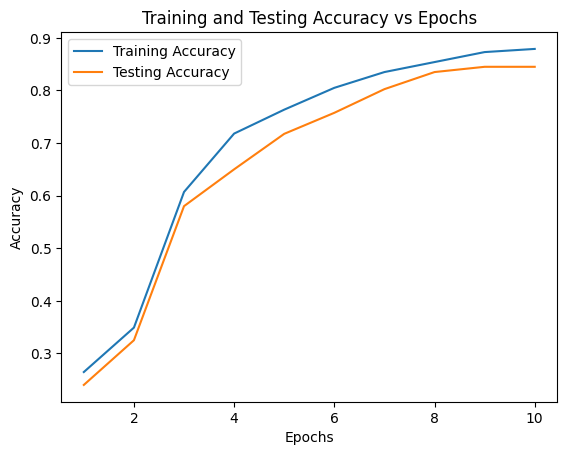

In [10]:
# plot the graphs here

plt.plot(range(1, epoch+1), training_accuracy_values, label='Training Accuracy')
plt.plot(range(1, epoch+1), testing_accuracy_values, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy vs Epochs')
plt.legend()
plt.show()

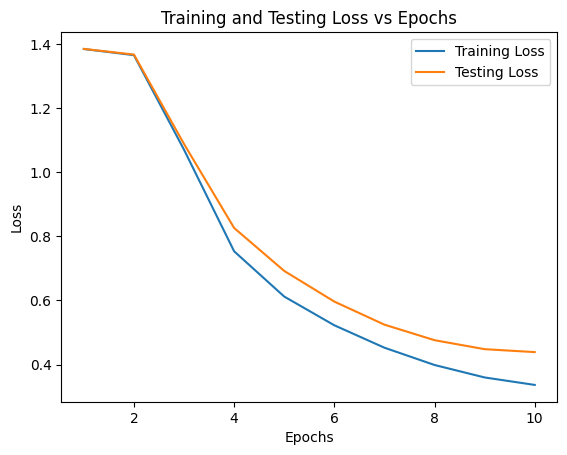

In [11]:
plt.plot(range(1, epoch+1), training_loss_values, label='Training Loss')
plt.plot(range(1, epoch+1), testing_loss_values, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss vs Epochs')
plt.legend()
plt.show()